In [37]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import pathlib
import glob
import copy

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [38]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
data_dir = r'E:\Image_processing\HW_3\dataset'

data_transforms = {

'train': transforms.Compose([
# put the input to Tensor format in order to use torch
transforms.Resize(256),
transforms.CenterCrop(227),
transforms.RandomRotation(degrees=25),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.6381, 0.6153, 0.6734], [0.2372, 0.2451, 0.2227])
]),

'valid': transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(227),
transforms.ToTensor(),
transforms.Normalize([0.6956, 0.6707, 0.7340], [0.1501, 0.1703, 0.1098])
]),

'test': transforms.Compose([
# put the input to Tensor format in order to use torch
transforms.Resize(256),
transforms.CenterCrop(227),
transforms.ToTensor(),
transforms.Normalize([0.6956, 0.6707, 0.7340], [0.1501, 0.1703, 0.1098])
])

}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
data_transforms[x]) for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}

In [57]:
#Calculating mean and std of images for the normalization
'''
train_data = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
mean = 0.
std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print("Mean:", mean)
print("Standard Deviation:", std)
'''

Mean: tensor([0.6405, 0.6178, 0.6760])
Standard Deviation: tensor([0.2336, 0.2419, 0.2188])


In [59]:
#categories
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

# Calculating the size of test and train set
train_count = dataset_sizes['train']
valid_count = dataset_sizes['valid']
test_count = dataset_sizes['test']

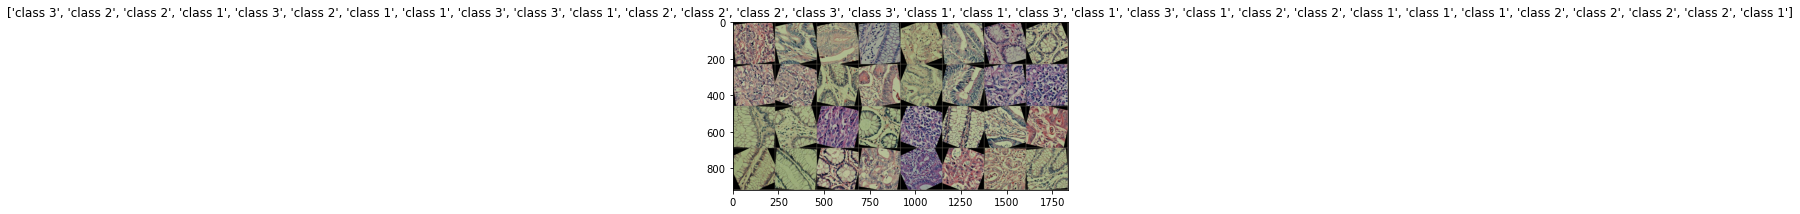

In [60]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [61]:
alexnet = models.alexnet(pretrained = True)

In [62]:
# Set hyperparameters
num_classes = 3
batch_size = 4
num_epochs = 5
learning_rate = 0.001

In [69]:
#freeze model parameters
for param in alexnet.parameters():
  param.requires_grad = False

# Change the final layer of alexnet
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet = alexnet.to(device)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [64]:
#define optimizer and loss function
from torch.optim import lr_scheduler


loss_criterion = nn.NLLLoss()
# optimizer = optim.Adam(alexnet.parameters())
optimizer = optim.SGD(alexnet.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [65]:
def train_and_validate(model, loss_criterion, optimizer, num_epochs):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        class_count_train = [0, 0, 0]  # Counter for each class: [class_1, class_2, class_3]
        correct_count_train = [0, 0, 0]  # Counter for correct predictions in each class
        
        class_count_valid = [0, 0, 0] 
        correct_count_valid = [0, 0, 0]  
        
        class_count_test = [0, 0, 0]  
        correct_count_test = [0, 0, 0] 

        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Update the counters for each class
            for c in range(3):
                class_count_train[c] += torch.sum(labels.data == c).item()
                correct_count_train[c] += torch.sum(correct_counts * (labels.data == c)).item()

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(dataloaders['valid']):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Update the counters for each class
                for c in range(3):
                    class_count_valid[c] += torch.sum(labels.data == c).item()
                    correct_count_valid[c] += torch.sum(correct_counts * (labels.data == c)).item()

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / train_count
        avg_train_acc = train_acc / train_count

        # Find average validation loss and validation accuracy
        avg_valid_loss = valid_loss / valid_count
        avg_valid_acc = valid_acc / valid_count

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Calculate and print the ratios for each class
        for c in range(3):
            class_ratio_train = correct_count_train[c] / class_count_train[c]
            class_ratio_valid = correct_count_valid[c] / class_count_valid[c]
            print("Training Class {}: Correct Predictions: {}, Total: {}, Ratio: {:.4f}".format(c+1, correct_count_train[c], class_count_train[c], class_ratio_train))
            print("Validation Class {}: Correct Predictions: {}, Total: {}, Ratio: {:.4f}".format(c+1, correct_count_valid[c], class_count_valid[c], class_ratio_valid))

        # Save if the model has the best accuracy till now
        # torch.save(model, "dataset"+'_model_'+str(epoch)+'.pt')

    return model, history

In [66]:

trained_model, history = train_and_validate(alexnet, loss_criterion, optimizer, num_epochs)


Epoch: 1/5
Batch number: 000, Training: Loss: 1.1786, Accuracy: 0.3750
Batch number: 001, Training: Loss: 1.1615, Accuracy: 0.2812
Batch number: 002, Training: Loss: 0.9287, Accuracy: 0.5938
Batch number: 003, Training: Loss: 0.8136, Accuracy: 0.6875
Batch number: 004, Training: Loss: 0.7445, Accuracy: 0.7188
Batch number: 005, Training: Loss: 0.9046, Accuracy: 0.6296
Validation Batch number: 000, Validation: Loss: 0.6539, Accuracy: 0.7812
Validation Batch number: 001, Validation: Loss: 0.5344, Accuracy: 0.8438
Validation Batch number: 002, Validation: Loss: 0.8324, Accuracy: 0.4615
Epoch : 001, Training: Loss: 0.9566, Accuracy: 54.5455%, 
		Validation : Loss : 0.6344, Accuracy: 75.3247%, Time: 17.4330s
Training Class 1: Correct Predictions: 30, Total: 63, Ratio: 0.4762
Validation Class 1: Correct Predictions: 18, Total: 25, Ratio: 0.7200
Training Class 2: Correct Predictions: 35, Total: 62, Ratio: 0.5645
Validation Class 2: Correct Predictions: 14, Total: 26, Ratio: 0.5385
Training Cl

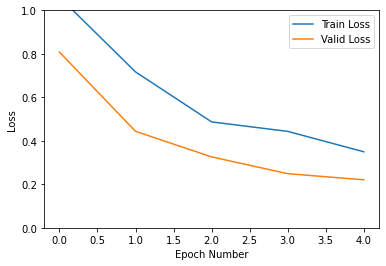

In [32]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig("Loss Curve.png")
plt.show()

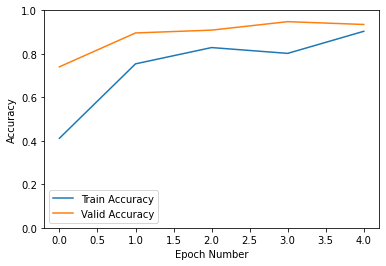

In [33]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig("Accuracy Curve.png")
plt.show()

In [67]:
def test_model(model, dataloader):

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for loss and accuracy
    test_loss = 0.0
    test_acc = 0.0
    class_count_test = [0, 0, 0] 
    correct_count_test = [0, 0, 0] 

    # No gradient tracking needed during testing
    with torch.no_grad():
        # Iterate over the test dataloader
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to test_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate test accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Update the counters for each class
            for c in range(3):
                class_count_test[c] += torch.sum(labels.data == c).item()
                correct_count_test[c] += torch.sum(correct_counts * (labels.data == c)).item()

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to test_acc
            test_acc += acc.item() * inputs.size(0)

    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / test_count
    avg_test_acc = test_acc / test_count

    # Calculate and print the ratios for each class
    for c in range(3):
        class_ratio_test = correct_count_test[c] / class_count_test[c]
        print("Test Class {}: Correct Predictions: {}, Total: {}, Ratio: {:.4f}".format(c + 1, correct_count_test[c], class_count_test[c], class_ratio_test))

    print("Test Loss: {:.4f}, Test Accuracy: {:.4f}%".format(avg_test_loss, avg_test_acc * 100))

    return avg_test_loss, avg_test_acc


In [68]:
test_loss, test_acc = test_model(alexnet, dataloaders['test'])


Test Class 1: Correct Predictions: 47, Total: 48, Ratio: 0.9792
Test Class 2: Correct Predictions: 43, Total: 57, Ratio: 0.7544
Test Class 3: Correct Predictions: 36, Total: 39, Ratio: 0.9231
Test Loss: 0.3059, Test Accuracy: 87.5000%
